OpenProblems / NeurIPS 2021 competition for multimodal single-cell data integration

https://github.com/openproblems-bio/neurips2021_multimodal_topmethods

In [1]:
import numpy as np
import pandas as pd

import os, gc, pickle, json

import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import tensorflow as tf

from config import *

2022-10-15 12:30:01.071461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/hadoop/lib/native/:/usr/local/cuda-9.0/targets/x86_64-linux/lib/:/usr/local/cuda-9.0/targets/x86_64-linux/lib64/:/usr/hadoop/lib/native/:/usr/local/cuda-9.0/targets/x86_64-linux/lib/:/usr/local/cuda-9.0/targets/x86_64-linux/lib64/::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/hadoop/lib/native:/usr/hadoop/lib/native/Linux-amd64-64
2022-10-15 12:30:01.071493: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [33]:
DATA_DIR = os.path.join(PATH_WORKING, 'data_cite_x512')
MODEL_DIR_nn = os.path.join(PATH_WORKING, 'nn_cite_x512')
MODEL_DIR_lgb = os.path.join(PATH_WORKING, 'lgb_cite_x512')

In [34]:
y_true = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values.astype('float32') 

In [35]:
mse_nn = np.zeros((140,))
mse_lgb = np.zeros((140,))

for k, (train_index, test_index) in enumerate(KFold(n_splits=10, shuffle=True, random_state=SEED*4).split(y_true)):

    y_fold_true = y_true[test_index]

    y_fold_nn = np.load(os.path.join(MODEL_DIR_nn, f'y_fold_{k}.npy'))
    y_fold_lgb = np.load(os.path.join(MODEL_DIR_lgb, f'y_fold_{k}.npy'))
    
    assert y_fold_true.shape == y_fold_nn.shape
    assert y_fold_true.shape == y_fold_lgb.shape
    assert y_fold_nn.shape == y_fold_lgb.shape
    
    # fix bounds for preds
    lb = np.min(y_fold_true, axis=0, keepdims=True)
    ub = np.max(y_fold_true, axis=0, keepdims=True)
    y_fold_nn = np.clip(y_fold_nn, lb, ub)
    y_fold_lgb = np.clip(y_fold_lgb, lb, ub)
    
    erros_nn = (y_fold_true - y_fold_nn)**2
    erros_lgb = (y_fold_true - y_fold_lgb)**2
    
    mse_nn += np.mean(erros_nn, axis=0)
    mse_lgb += np.mean(erros_lgb, axis=0)

mse_nn /= 10
mse_lgb /= 10

In [41]:
idx = np.where(mse_lgb < mse_nn)[0]
print(len(idx))
idx

81


array([  0,   3,   4,   5,   6,   7,   8,   9,  13,  14,  15,  16,  17,
        18,  20,  21,  24,  28,  29,  30,  37,  42,  43,  44,  45,  48,
        50,  51,  52,  54,  55,  57,  58,  60,  61,  64,  68,  69,  70,
        71,  73,  75,  77,  79,  80,  81,  82,  86,  88,  89,  91,  92,
        94,  95,  97,  99, 100, 104, 106, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 127, 130, 131, 133, 134, 136,
       137, 138, 139])

In [37]:
y_fold_true

array([[ 2.0027757 , -0.14023319, -0.04327662, ...,  0.36001372,
        -1.2928327 ,  1.597052  ],
       [-0.28304344,  0.04797234,  0.14927372, ..., -0.20170508,
         1.2102768 ,  6.675041  ],
       [-0.71534777, -0.49915326, -0.41048253, ..., -0.7506912 ,
         1.5325812 ,  1.217305  ],
       ...,
       [-0.41715258,  1.7934265 ,  0.06119077, ...,  0.6489624 ,
         1.8710786 ,  3.0164864 ],
       [-0.23028766,  0.3895501 ,  1.3501713 , ..., -0.444369  ,
         2.7940578 ,  4.698568  ],
       [-0.14509758, -0.34723133,  1.6988021 , ...,  1.0188603 ,
         1.8840111 ,  5.6001663 ]], dtype=float32)

In [42]:
idxs = np.where(y_fold_nn < 0)
y_fold_nn[idxs[0], idxs[1]]

array([-0.22213432, -0.12991849, -0.01208161, ..., -0.19248216,
       -0.12941684, -0.5071277 ], dtype=float32)

In [25]:
idxs = np.where(y_fold_lgb < 0)
y_fold_lgb[idxs[0], idxs[1]]

array([-0.02166236, -0.09636224, -0.01011171, ..., -0.01659816,
       -0.0649613 , -0.01141472])

Text(0.5, 1.0, 'Evolution of val_loss')

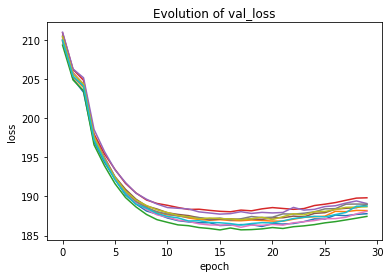

In [2]:
MODEL_DIR = os.path.join(PATH_WORKING, 'pdl_cite_x512')

fig, ax = plt.subplots()

for k in range(10):
    data = json.load(open(os.path.join(MODEL_DIR, f'fold_{k}', 'history.json'), 'r'))
    ax.plot(data['val_loss'])

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Evolution of val_loss')

In [54]:
MODEL_DIR = os.path.join(PATH_WORKING, 'pdl_cite_x512')
k = 0
n_samples = 100

y_true = np.load(os.path.join(MODEL_DIR, f'fold_{k}', 'samples', 'y_true.npy'))

preds = [np.load(os.path.join(MODEL_DIR, f'fold_{k}', 'samples', f'y_pred_{i}.npy')) for i in range(n_samples)]
y_bayes = sum(preds)/n_samples

y_freq = np.load(os.path.join(PATH_WORKING, 'nn_cite_x512', f'y_fold_{k}.npy'))

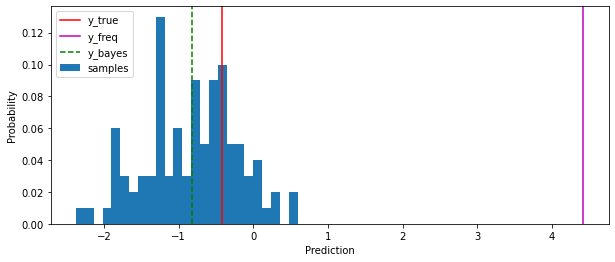

In [61]:
i = 10; j = 3;
#data = [y_pred[i,j] for y_pred in preds]

fig, ax = plt.subplots(figsize=(10, 4))

ax.hist(data, bins=25, weights=(1/n_samples)*np.ones(n_samples), label='samples')
ax.axvline(y_true[i,j], linestyle='solid', color='r', label='y_true')
ax.axvline(y_freq[i,j], linestyle='solid', color='m', label='y_freq')
ax.axvline(y_bayes[i,j], linestyle='dashed', color='g', label='y_bayes')
#ax.axvline(np.median(data), linestyle='dashed', color='m', label='median')
        
ax.set_xlabel('Prediction')
ax.set_ylabel('Probability')

ax.legend()

In [4]:
np.mean([])

/home/datashare/envs/rden-py37-tf-cpu/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/datashare/envs/rden-py37-tf-cpu/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [3]:
from builder import build_cite_selfsv
model = build_cite_selfsv(n_inputs=512, n_outputs=140, n_units=256, rate=0.3, l2=1e-3)
model.summary()

2022-10-15 22:11:58.488368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/hadoop/lib/native/:/usr/local/cuda-9.0/targets/x86_64-linux/lib/:/usr/local/cuda-9.0/targets/x86_64-linux/lib64/:/usr/hadoop/lib/native/:/usr/local/cuda-9.0/targets/x86_64-linux/lib/:/usr/local/cuda-9.0/targets/x86_64-linux/lib64/::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/hadoop/lib/native:/usr/hadoop/lib/native/Linux-amd64-64
2022-10-15 22:11:58.488499: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/hadoop/lib/native/:/usr/local/cuda-9.0/targets/x86_64-linux/lib/:/usr/local/cuda-9.0/target

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256)          198144      input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          99712       sequential[0][0]                 
__________________________________________________________________________________________________
tf.compat.v1.shape (TFOpLambda) (2,)                 0           sequential_2[0][0]               
______________________________________________________________________________________________

In [12]:
model.layers[-3].outputs

[<KerasTensor: shape=(None, 140) dtype=float32 (created by layer 'dense_3')>]

In [7]:
model.layers